# WNTR simulations without MiniCPS
### These simulations are simply WNTR simulations that do not use MiniCPS, these simulations are used a baseline to validate the other simulations

In [9]:
import matplotlib.pyplot as plt
import wntr
import wntr.network.controls as controls
import sqlite3
import csv
import time
import pandas as pd

In [4]:
# Create the network
inp_file = '../EPANET_topologies/minitown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Set option for step-by-step simulation
wn.options.time.duration = 900
wn.options.time.hydraulic_timestep = 900
wn.options.time.pattern_timestep = 3600
linkStatus = wntr.network.base.LinkStatus

result_list = [["timestamps", "PRESSURE_TANK", "FLOW_PUMP1", "FLOW_PUMP2", "STATUS_PUMP1", "STATUS_PUMP2", "Attack#01", "Attack#02"]]  # results list

# SET THE RIGHT DATA IN DB

tank = wn.get_node("TANK")    # WNTR TANK OBJECT
pump1 = wn.get_link("PUMP1")  # WNTR PUMP OBJECT
pump2 = wn.get_link("PUMP2")  # WNTR PUMP OBJECT

condition_pump1_open = controls.ValueCondition(tank, 'level', '<', 4.0)
condition_pump1_close = controls.ValueCondition(tank, 'level', '>', 6.3)

condition_pump2_open = controls.ValueCondition(tank, 'level', '<', 1)
condition_pump2_close = controls.ValueCondition(tank, 'level', '>', 4.5)

pump1_open = controls.ControlAction(pump1, 'status', 1)
pump1_close = controls.ControlAction(pump1, 'status', 0)

pump2_open = controls.ControlAction(pump2, 'status', 1)
pump2_close = controls.ControlAction(pump2, 'status', 0)

pump1_control_open = controls.Control(condition_pump1_open, pump1_open, name='pump1control1')
pump1_control_close = controls.Control(condition_pump1_close, pump1_close, name='pump1control2')

pump2_control_open = controls.Control(condition_pump2_open, pump2_open, name='pump2control1')
pump2_control_close = controls.Control(condition_pump2_close, pump2_close, name='pump2control2')

wn.add_control('WnPump1Control1', pump1_control_open)
wn.add_control('WnPump1Control2', pump1_control_close)

wn.add_control('WnPump2Control1', pump2_control_open)
wn.add_control('WnPump2Control2', pump2_control_close)

sim = wntr.sim.WNTRSimulator(wn) 

In [13]:
# START STEP BY STEP SIMULATION
iteration = 0
while iteration <= 672:
    results = sim.run_sim(convergence_error=True)
    result_list.append([results.timestamp, tank.level,pump1.flow, pump2.flow, pump1.status, pump2.status])
    iteration += 1

In [6]:
sim_2 = wntr.sim.WNTRSimulator(wn, mode='PDD')
results_list_pdd = [["timestamps", "PRESSURE_TANK", "FLOW_PUMP1", "FLOW_PUMP2", "STATUS_PUMP1", "STATUS_PUMP2", "Attack#01", "Attack#02"]]  # results list    
# START STEP BY STEP SIMULATION
iteration = 0
while iteration <= 672:
    results_pdd = sim_2.run_sim(convergence_error=True)
    results_list_pdd.append([results.timestamp, tank.level,pump1.flow, pump2.flow, pump1.status, pump2.status])
    iteration += 1

In [7]:
with open('no_minicps.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(result_list)
    
with open('no_minicps_pdd.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(result_list)

In [10]:
no_minicps_data = pd.read_csv('no_minicps.csv')
no_minicps_data_pdd = pd.read_csv('no_minicps_pdd.csv')

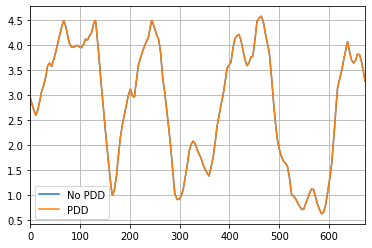

In [12]:
fig, ax = plt.subplots()
no_minicps_data['PRESSURE_TANK'].plot(label='No PDD', ax=ax )
no_minicps_data_pdd['PRESSURE_TANK'].plot(label='PDD', ax=ax )
leg = ax.legend()
ax.grid(True)